In [1]:
%matplotlib inline
import numpy as np
import math
import matplotlib.pyplot as plt
import random
import scipy.signal as sp

## Class definition

In [2]:
class hh_neuron:
    
    def __init__(self, config={}):
        
        self.C = 1.
        self.g_Na = 120.
        self.g_K = 36.
        self.g_L = .3
        self.E_Na = 50.
        self.E_K = -77.
        self.E_L = -54.5
        self.I_ext = 10.
        self.I_syn = 0.
        self.tau_d = 3.
        self.tau_r = .1
        self.sim_n = 1

        
        if 'C' in config.keys():
            self.C = config['C']
        if 'g_Na' in config.keys():
            self.g_Na = config['g_Na']
        if 'g_K' in config.keys():
            self.g_K = config['g_K']
        if 'g_L' in config.keys():
            self.g_L = config['g_L']
        if 'E_Na' in config.keys():
            self.E_Na = config['E_Na']
        if 'E_K' in config.keys():
            self.E_K = config['E_K']
        if 'E_L' in config.keys():
            self.E_L = config['E_L']
        if 'I_ext' in config.keys():
            self.I_ext = config['I_ext']
        if 'I_syn' in config.keys():
            self.I_syn = config['I_syn']
        if 'tau_d' in config.keys():
            self.tau_d = config['tau_d']
        if 'tau_r' in config.keys():
            self.tau_r = config['tau_r']

    def alpha_m(self, V):
        """S5"""
        return .1 * (V + 40.) / (1. - np.exp(-(V + 40.) / 10.))

    def beta_m(self, V):
        """S6"""
        return 4. * np.exp(-(V + 65.) / 18.)

    def alpha_h(self, V):
        """S7"""
        return .07 * np.exp(-(V + 65.) / 20.)

    def beta_h(self, V):
        """S8"""
        return 1. / (1. + np.exp(-(V + 35.) / 10.))

    def alpha_n(self, V):
        """S9"""
        return ((V + 55.) / 100.) / (1. - np.exp(-.1 * (V + 55.)))

    def beta_n(self, V):
        """S10"""
        return .125 * np.exp(-(V + 65.) / 80.)

    def dm(self, V, m):
        """S2"""
        a = self.alpha_m(V)
        b = self.beta_m(V)

        return a * (1. - m) - b * m

    def dh(self, V, h):
        """S3"""
        a = self.alpha_h(V)
        b = self.beta_h(V)

        return a * (1. - h) - b * h

    def dn(self, V, n):
        """S4"""
        a = self.alpha_n(V)
        b = self.beta_n(V)

        return a * (1. - n) - b * n

    def dV(self, V, m, h, n):
        """S1"""
        return (- self.g_Na * m ** 3 * h * (V - self.E_Na) 
                - self.g_K * n ** 4 * (V - self.E_K) 
                - self.g_L * (V - self.E_L) 
                + self.I_ext + self.I_syn ) / self.C

## Configuration

In [3]:
hh_config = {
    'C': 1.,
    'g_Na': 120.,
    'g_K': 36.,
    'g_L': .3,
    'E_Na': 50.,
    'E_K': -77.,
    'E_L': -54.5,
    'I_ext': 10.
}

#tau_d = 3.
#tau_r = .1
#N = 500.

#amount of neurons
nr_neurons = 3

#set time
step_size = .02
t0 = 0.
t_end = 200.
t = np.arange(t0, t_end, step_size)

#range of possible initial values
m0_range = np.linspace(0.001,0.999,100)
h0_range = np.linspace(0.001,0.999,100)
n0_range = np.linspace(0.001,0.999,100)
v0_range = np.linspace(-75,-10,100)

#initialize values
m = np.zeros((t.size,nr_neurons))
m[0,:] = [m0_range[random.randint(0,99)] for i in range(nr_neurons)]
h = np.zeros((t.size, nr_neurons))
h[0] = [h0_range[random.randint(0,99)] for i in range(nr_neurons)]
n = np.zeros((t.size, nr_neurons))
n[0] = [n0_range[random.randint(0,99)] for i in range(nr_neurons)] 
V = np.zeros((t.size, nr_neurons))
V[0] = [v0_range[random.randint(0,99)] for i in range(nr_neurons)]

neurons = [hh_neuron(hh_config) for _ in range(nr_neurons)]
print(t.astype(int))

[  0   0   0 ... 199 199 199]


## Simulation

In [4]:
for j, neuron in enumerate(neurons):

    for i in range(1, t.size):
    
        # intermediate
        m_i = m[i - 1,j] + step_size * neuron.dm(V[i - 1,j], m[i - 1,j])
        h_i = h[i - 1,j] + step_size * neuron.dh(V[i - 1,j], h[i - 1,j])
        n_i = n[i - 1,j] + step_size * neuron.dn(V[i - 1,j], n[i - 1,j])
        V_i = V[i - 1,j] + step_size * neuron.dV(V[i - 1,j], m[i-1,j], h[i-1,j], n[i-1,j])

        # heun
        m[i,j] = m[i - 1,j] + (step_size / 2.) * (neuron.dm(V[i - 1,j], m[i - 1,j]) + neuron.dm(V_i, m_i))
        h[i,j] = h[i - 1,j] + (step_size / 2.) * (neuron.dh(V[i - 1,j], h[i - 1,j]) + neuron.dh(V_i, h_i))
        n[i,j] = n[i - 1,j] + (step_size / 2.) * (neuron.dn(V[i - 1,j], n[i - 1,j]) + neuron.dn(V_i, n_i))

        V_i = V[i - 1,j] + step_size * neuron.dV(V[i - 1,j], m[i-1,j], h[i-1,j], n[i-1,j])
        V[i,j] = V[i - 1,j] + (step_size / 2.) * (neuron.dV(V[i - 1,j], m[i-1,j], h[i-1,j], n[i-1,j]) + neuron.dV(V_i, m[i,j], h[i,j], n[i,j]))



## Plotting

Text(0.5, 1.0, 'N')

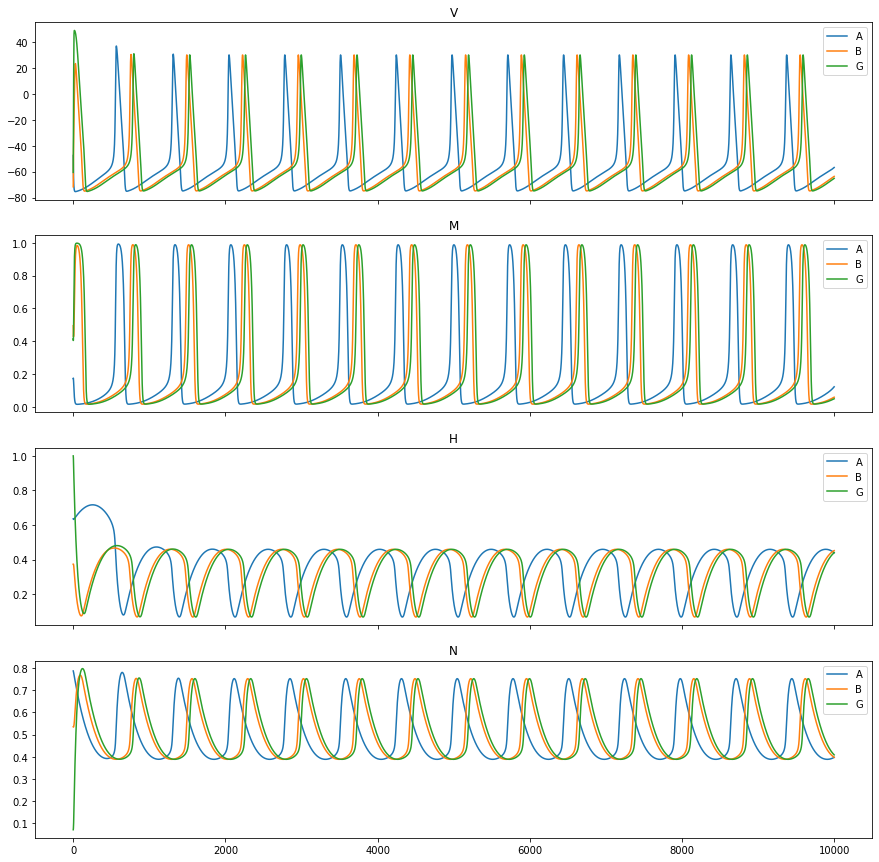

In [5]:
fig, ax = plt.subplots(4, 1, figsize=(15,15),sharex=True)


for i in range(nr_neurons):
    ax[0].plot(V[:,i])
    ax[1].plot(m[:,i])
    ax[2].plot(h[:,i])
    ax[3].plot(n[:,i])

ax[0].legend("ABG",loc="upper right")
ax[1].legend("ABG",loc="upper right")
ax[2].legend("ABG",loc="upper right")
ax[3].legend("ABG",loc="upper right")

ax[0].set_title("V")
ax[1].set_title("M")
ax[2].set_title("H")
ax[3].set_title("N")



## Connections

In [6]:
def alpha(t, neuron):
    
    return (1/(tau_d - tau_r))*(np.exp((-t/tau_d)) - np.exp((-t/tau_r)))

def I_syn_calc(N, t, t_spike, tau_l, V, E_syn, neuron):
    
    #TODO: sum over different latencies
    g_max = 0.05
    
    return  -(g_max) * np.sum([alpha(t - spike - tau_l, neuron) * (V - E_syn) for spike in t_spike])

def get_spike_times(t,V):
    return t[sp.argrelextrema(V,np.greater)]

In [7]:
N = 500
tau_l = 0.8 #TODO: latencies as distribution
E_syn = 0 #Excitatory: 0, Inhibitory: -80
old_I = 0
t_spike = 0



#range of possible initial values
tau_d_range = np.linspace(0.1,7,100)
tau_r_range = np.linspace(0.1,7,100)

#initialize values
tau_d = np.zeros(nr_neurons)
#tau_d[:] = [tau_d_range[random.randint(0,99)] for i in range(nr_neurons)]
tau_d[:] = 3
tau_r = np.zeros(nr_neurons)
#tau_r[:] = [tau_r_range[random.randint(0,99)] for i in range(nr_neurons)]
tau_r[:] = 0.1


print(t.astype(int))

[  0   0   0 ... 199 199 199]


In [8]:
for j, neuron in enumerate(neurons):

    for i in range(1, t.size):
        
        spikes = get_spike_times(t, V[:,j])   
        I_syn = I_syn_calc(N,t[i], spikes, tau_l, V[i,j], E_syn, j)
        
        
        # intermediate
        m_i = m[i - 1,j] + step_size * neuron.dm(V[i - 1,j], m[i - 1,j])
        h_i = h[i - 1,j] + step_size * neuron.dh(V[i - 1,j], h[i - 1,j])
        n_i = n[i - 1,j] + step_size * neuron.dn(V[i - 1,j], n[i - 1,j])
        V_i = V[i - 1,j] + step_size * neuron.dV(V[i - 1,j], m[i-1,j], h[i-1,j], n[i-1,j])

        # heun
        m[i,j] = m[i - 1,j] + (step_size / 2.) * (neuron.dm(V[i - 1,j], m[i - 1,j]) + neuron.dm(V_i, m_i))
        h[i,j] = h[i - 1,j] + (step_size / 2.) * (neuron.dh(V[i - 1,j], h[i - 1,j]) + neuron.dh(V_i, h_i))
        n[i,j] = n[i - 1,j] + (step_size / 2.) * (neuron.dn(V[i - 1,j], n[i - 1,j]) + neuron.dn(V_i, n_i))

        V_i = V[i - 1,j] + step_size * neuron.dV(V[i - 1,j], m[i-1,j], h[i-1,j], n[i-1,j])
        V[i,j] = V[i - 1,j] + (step_size / 2.) * (neuron.dV(V[i - 1,j], m[i-1,j], h[i-1,j], n[i-1,j]) + neuron.dV(V_i, m[i,j], h[i,j], n[i,j]))
        
      
            

<ipython-input-6-3bec809939f3>:3: RuntimeWarning: overflow encountered in exp
  return (1/(tau_d - tau_r))*(np.exp((-t/tau_d)) - np.exp((-t/tau_r)))
<ipython-input-6-3bec809939f3>:10: RuntimeWarning: overflow encountered in multiply
  return  -(g_max) * np.sum([alpha(t - spike - tau_l, neuron) * (V - E_syn) for spike in t_spike])
/Users/Emilia/anaconda3/envs/nd/lib/python3.8/site-packages/numpy/core/fromnumeric.py:87: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


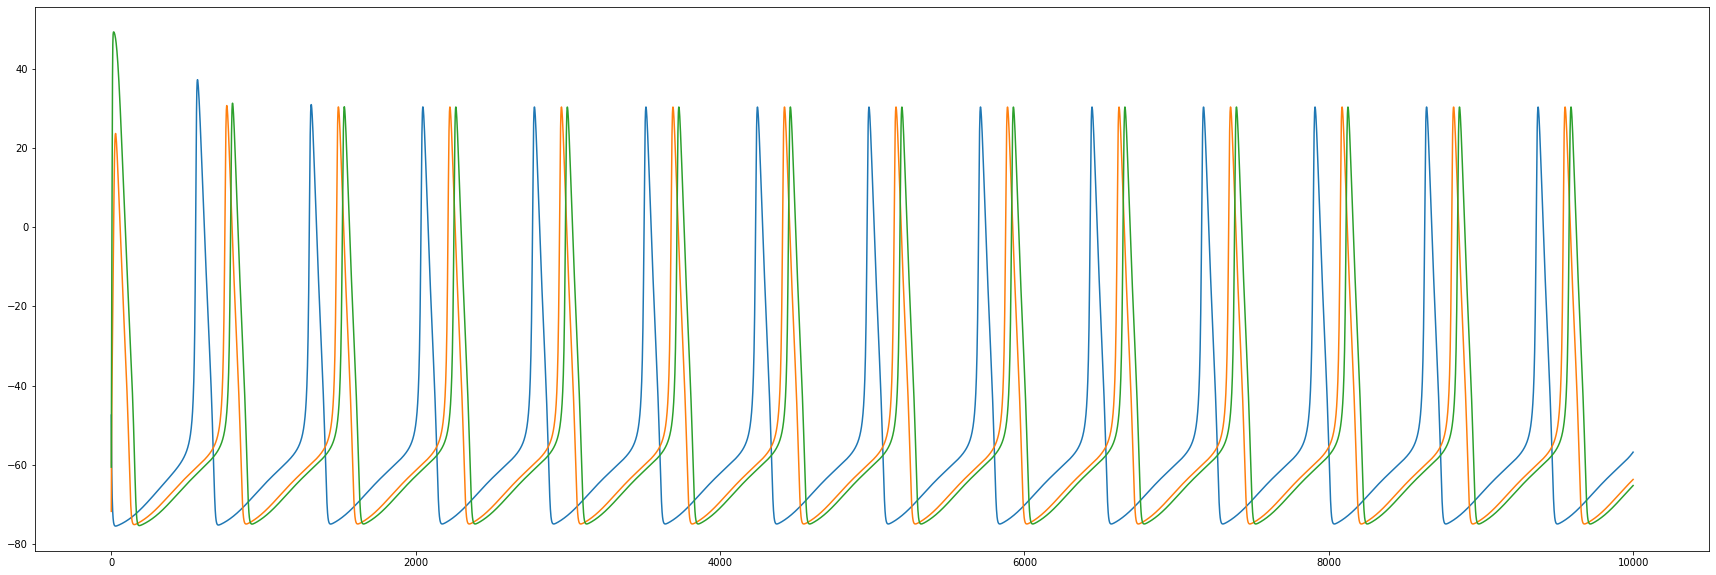

In [9]:
fig, ax = plt.subplots(1,1, figsize=(30,10))

ax.plot(V[:,0])
ax.plot(V[:,1])
ax.plot(V[:,2])



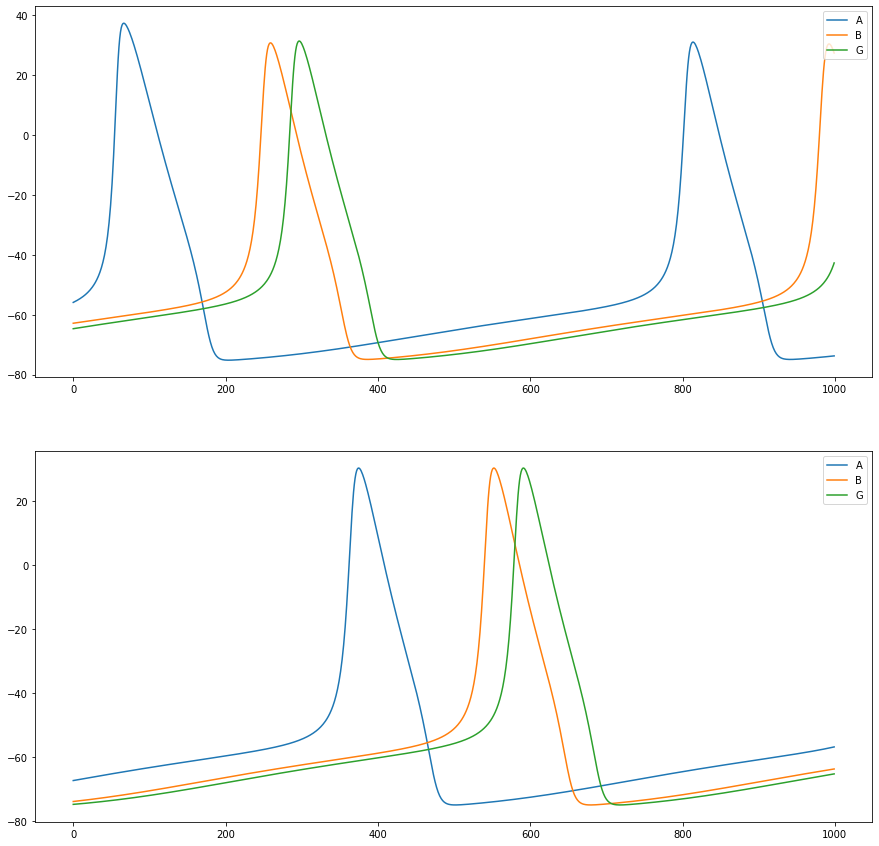

In [10]:
fig, ax = plt.subplots(2,1, figsize=(15,15))

ax[0].plot(V[500:1500,0])
ax[0].plot(V[500:1500,1])
ax[0].plot(V[500:1500,2])
ax[0].legend("ABG",loc="upper right")

ax[1].plot(V[9000:,0])
ax[1].plot(V[9000:,1])
ax[1].plot(V[9000:,2])
ax[1].legend("ABG",loc="upper right")

